## Document Overview

Tracking data has allowed us to record vital information during football games, with around 2000 events being tracked per game. Included in this is metadata that describes the location of the ball during every action, the foot/head it was kicked with, whether or not the event was a set piece or not.

#### The Problem

Football is a very low scoring game. Therefore, football analysts may not derive the correct inference from analysing only the number of goals a team scores, as over even a reasonably large sample size there is a very large amount of 'luck' or random error. Analysing the choice to shoot, or the performance of a team in a specific game, we must go beyond looking at either a) did the shot end in a goal or b) did the team win the match. This allows analysts and coaches to better create repeatable performance behaviours.

These two concrete cases are the motivation for this project. By analysing event data, we will see if we can derive an estimate for "how likely was that to end up as a goal, based on the position it was shot from" - this is crucial for then analysing whether there was a better option for the player (e.g. passing - although the other options are out of scope for this project). Secondly, by looking at aggregated event data across a whole match, we will see how accurately we are able to predict the result in a given match. This understanding of the 'input metrics' which often lead to strong performance metrics will allow coaches to be able to correctly analyse the performance of a team in a match, even if the score does not necessarily reflect the overall play.


### Sections

#### [Section 1 - Loading the data](#1)

#### [Section 2 - Data exploration, getting acquainted with the different metrics available](#2)

#### [Section 3 - Creating dummy variables / scaling data when appropriate](#3)

#### [Section 4 - Building and analysing the "Expected goal (shot value)" models](#4)
        
#####   --[4a - MinMax scaling and polynomial features](#4a)
        
#####   --[4b - Logistic regression](#4b)
        
#####   --[4c - ROC-AUC curve](#4c)
        
#####   --[4d - Decision Tree](#4d)
        
#####   --[4e - Random forest and Stacking](#4e)

#####   --[4f - Threshold optimisation](#4f)
        
#####   --[4g - Test Set](#4g)
        
#### [Section 5 - Predicting match outcome using the expected goal (shot value) model](#5)

#####   --[5a - What's the base case?](#5a)
        
#####   --[5b - Linear regression](#5b)
        
#####   --[5c - Logistic regression](#5c)
        
#####   --[5d - KNN](#5d)
        
#####   --[5e - Using Bayes theory to solve the problem analytically](#5e)
        
#####   --[5f - Test Set](#5f)

In [4]:
import numpy as np 
import pandas as pd 
import json
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from matplotlib.offsetbox import  OffsetImage
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import os

<a name='1'></a>

## Section 1 - Loading the data

## Initially let's load Events, team and match data

Data comes from top 5 eu leaves, plus euros and world cup 
https://figshare.com/collections/Soccer_match_event_dataset/4415000/5



In [5]:
np.random_state = 1
r_seed = 1

In [6]:
#start with one events file
event_data_file = '/Users/jacoblourie/events_data/events1/events_England.json'
df = pd.read_json(event_data_file)

In [ ]:
#then do the rest
events_data_folder = os.listdir('/Users/jacoblourie/events_data/events1/')
for suffix in events_data_folder:
    if 'England' not in suffix:
        df = df.append(pd.read_json('/Users/jacoblourie/events_data/events1/'+suffix))

In [ ]:
df = df.reset_index().drop(columns='index')

In [ ]:
#also load the teams data
with open('/Users/jacoblourie/events_data/teams.json', 'r') as f:
    teams = json.load(f)

In [ ]:
#put it into an easy to use dictionary
teams_dict = {}
for team in teams:
    teams_dict[team['wyId']] = team['name']

In [ ]:
#Now let's load the matches data - one example
match_dir = '/Users/jacoblourie/events_data/matches/'
matches_df = pd.read_json(match_dir+'matches_England.json')
#and load athe rest
match_suffixes = os.listdir(match_dir)
for suffix in match_suffixes:
    if 'England' not in suffix:
        matches_df = matches_df.append(pd.read_json(match_dir+suffix))

In [ ]:
#now apply functions to add home team id and name, and the score - THIS IS VERY FIDDLY, YOU HAVE TO LOOK INTO THE TEAMS DATA COLUMN TO UNDERSTAND IT.
matches_df['home_team_id'] = matches_df['teamsData'].apply(lambda x: x[list(x.keys())[0]]['teamId'] if x[list(x.keys())[0]]['side'] == 'home' else x[list(x.keys())[1]]['teamId'])
matches_df['away_team_id'] = matches_df['teamsData'].apply(lambda x: x[list(x.keys())[1]]['teamId'] if x[list(x.keys())[1]]['side'] == 'away' else x[list(x.keys())[0]]['teamId'])

matches_df['home_team_score'] = matches_df['teamsData'].apply(lambda x: x[list(x.keys())[0]]['score'] if x[list(x.keys())[0]]['side'] == 'home' else x[list(x.keys())[1]]['score'])
matches_df['away_team_score'] = matches_df['teamsData'].apply(lambda x: x[list(x.keys())[1]]['score'] if x[list(x.keys())[1]]['side'] == 'away' else x[list(x.keys())[0]]['score'])
matches_df['home_team'] = matches_df['home_team_id'].apply(lambda x: teams_dict[x])
matches_df['away_team'] = matches_df['away_team_id'].apply(lambda x: teams_dict[x])


In [ ]:
#Finally, let's load the competitions data in
with open('/Users/jacoblourie/events_data/competitions.json', 'r') as f:
    competitions = json.load(f)
competitions_dict = {}
for comp in competitions:
    competitions_dict[comp['wyId']] = comp['name']

In [ ]:
#and add this to the matches_df table
matches_df['competition'] = matches_df['competitionId'].apply(lambda x: competitions_dict[x])

In [ ]:
matches_df.head(2)

## Output 

We now have all matches with the team and score

<a name='2'></a>
## Section 2 - Event deep dive and understanding the data

This section looks at what the event data means.

First let's look at the first 10 lines. There is an event, a sub event, player id, location of the event (and end location, in some cases), match_ID

We can add meta data from the matches table so we have competition ID and name(we will worry about other columns later)

In [ ]:
#gets a dict of match ID versus comp name / ID
comp_match_id_pairs = (matches_df[['wyId', 'competitionId']].set_index('wyId').T.to_dict(orient='index'))
comp_match_name_pairs = (matches_df[['wyId', 'competition']].set_index('wyId').T.to_dict(orient='index'))

In [ ]:
#just looking at top 10 lines - note there is always just one player ID. we should look at how 'touch works.
df['competition_ID'] = df['matchId'].apply(lambda x: comp_match_id_pairs['competitionId'][x])
df['competition_name'] = df['matchId'].apply(lambda x: comp_match_name_pairs['competition'][x])

In [ ]:
df.head(1)

## What high level and sub level events do we have

In [ ]:
#Let's look at all the high level events
pd.DataFrame(round(df['eventName'].value_counts(normalize=True),2)).T

In [ ]:
#Lets have a look at all the events in subEvent.
df['subEventName'].value_counts(normalize=True).T

## We can also see from the main table that there are a bunch of tags.

To understand those tag, we need to add in the tag dictionary: https://github.com/Friends-of-Tracking-Data-FoTD/mapping-match-events-in-Python/tree/master/data

In [ ]:
tags_file = '/Users/jacoblourie/Downloads/tags2name.csv'
tags_df = pd.read_csv(tags_file)

In [ ]:
tags_df

## We care about tags that may be relevant in predicting whether a shot will go in or not

So all shots are "event names" : 'shot'

we have free kick and penalty shot as subevents

Some relevant tags:

101: goal

401: left foot, 402: right foot, 403: head, 

1901: counter attack, 201: opportunity

## Unpacking the coordinates - what do the x and y coordinates actually refer to. Are they expressed in terms of the home team, or the player with the ball, and is x or y length wise on the pitch?

let's draw them on the pitch to view it properly

In [ ]:
#extracts just x and y from the first event in the event location data
df['event_location_y'] = df['positions'].apply(lambda x: x[0]['y'])
df['event_location_x'] = df['positions'].apply(lambda x: x[0]['x'])

In [11]:
def draw_pitch(ax):

    # size of the pitch is 100, 100
    #Create figure

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,100], color="black")
    plt.plot([0,100],[100,100], color="black")
    plt.plot([100,100],[100,0], color="black")
    plt.plot([100,0],[0,0], color="black")
    plt.plot([50,50],[0,100], color="black")

    #Left Penalty Area
    plt.plot([14.6,14.6],[67.8,32.2],color="black")
    plt.plot([0,14.6],[67.8,67.8],color="black")
    plt.plot([0,14.6],[32.2,32.2],color="black")

    #Right Penalty Area
    plt.plot([85.4,85.4],[67.8,32.2],color="black")
    plt.plot([100,85.4],[67.8,67.8],color="black")
    plt.plot([100, 85.4],[32.2,32.2],color="black")

    #Left 6-yard Box
    plt.plot([0,4.9],[58,58],color="black")
    plt.plot([4.9,4.9],[58,42],color="black")
    plt.plot([0,4.9],[42,42],color="black")

    #Right 6-yard Box
    plt.plot([100,95.1],[58,58],color="black")
    plt.plot([95.1,95.1],[58,42],color="black")
    plt.plot([100,95.1],[42,42],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((50,50),8.1,color="black",fill=False)
    centreSpot = plt.Circle((50,50),0.71,color="black")
    leftPenSpot = plt.Circle((9.7,50),0.71,color="black")
    rightPenSpot = plt.Circle((90.3,50),0.71,color="black")

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    # arguments for arc
    # x, y coordinate of centerpoint of arc
    # width, height as arc might not be circle, but oval
    # angle: degree of rotation of the shape, anti-clockwise
    # theta1, theta2, start and end location of arc in degree
    leftArc = Arc((9.7,50),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((90.3,50),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
    ax.set_facecolor('green')

In [ ]:
fig=plt.figure()
fig.set_size_inches(7, 7)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax)
plt.scatter(x=df[df['eventName']=='Shot']['event_location_x'],y=df[df['eventName']=='Shot']['event_location_y'],alpha=0.1,cmap='White',edgecolors='white')
plt.show()

## Key point of data - X is distance from the goal you're attacking.

Y is distance from left touchline

So let's create dummy variables for all our 'of interest' things

<a name='3'></a>
## Section 3 - creating dummy variables for variable of interest.

In [ ]:
#is penalty?
df['is_penalty'] = (df['subEventName'] == 'Penalty').astype('int')
#is freekick?
df['is_freekick'] = (df['subEventName'] == 'Free kick shot').astype('int')
#is goal?
def extract_tag(tags, tag):
    if tag in [x['id'] for x in tags]:
        return 1
    else:
        return 0
df['goal'] = df['tags'].apply(lambda x: extract_tag(x,101))
#additional tags
df['left_foot'] = df['tags'].apply(lambda x: extract_tag(x,401))
df['right_foot'] = df['tags'].apply(lambda x: extract_tag(x,402))
df['head'] = df['tags'].apply(lambda x: extract_tag(x,403))
df['counter_attack'] = df['tags'].apply(lambda x: extract_tag(x,1901))
df['opportunity'] = df['tags'].apply(lambda x: extract_tag(x,201))


And now let's create a goal distance and angle based on x y

In [ ]:
import math
from math import acos, cos, asin, sin, atan

In [ ]:
#use pythagoras
df['distance_to_goal'] = np.sqrt((100-df['event_location_x'])**2+(50-df['event_location_y'])**2)
#create 'opposite over adjacent'
df['angle_to_goal_calc'] = (abs(50-df['event_location_y'])/(100-df['event_location_x']))
#take inverse tan of that and convert to degrees
df['angle_to_goal'] = df['angle_to_goal_calc'].apply(lambda x: (180/np.pi)*atan(x))

## Important

non-shot actions, such as 'reflex save' are also labelled as 'penalty' for example. So we need to make sure to filter on 'subevent' == 'shot, freekick shot or penalty' at all times. We can't use Event == 'shot' because this doesn't include free kick or penalty shots


In [151]:
#Saving files up till now for ease
with open('saved_dfs/matches_with_meta','w') as f:
    matches_df.to_csv(f)
with open('saved_dfs/event_data_with_meta_and_dummies','w') as f:
    df.to_csv(f)

In [6]:
matches_df = pd.read_csv('saved_dfs/matches_with_meta')

In [7]:
df = pd.read_csv('saved_dfs/event_data_with_meta_and_dummies')

In [8]:
ev_filter = ['Shot','Free kick shot','Penalty']

In [9]:
df[df['subEventName'].isin(ev_filter)]['goal'].value_counts()

0    40839
1     5106
Name: goal, dtype: int64

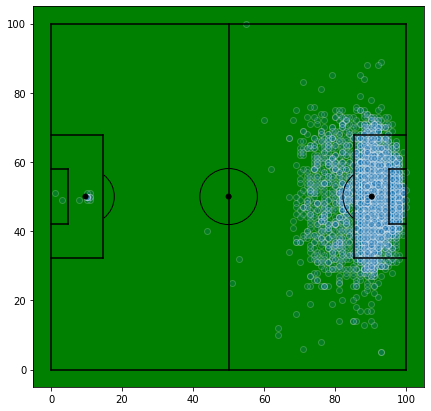

In [12]:
#let's take a look at where the goals are scored fro
goal_data = df[(df['goal']==1) & (df['subEventName'].isin(ev_filter))]
fig=plt.figure()
fig.set_size_inches(7, 7)
ax=fig.add_subplot(1,1,1)
draw_pitch(ax)
plt.scatter(x=goal_data['event_location_x'],y=goal_data['event_location_y'],alpha=0.2,cmap='White',edgecolors='white')
plt.show()

This all looks good, the goals are obviously coming much more from closer to the goal!

## Let's plot histograms of shots for angle to goal for goals and total shots

In [28]:
import plotly
from plotly import graph_objects as go
from plotly import subplots

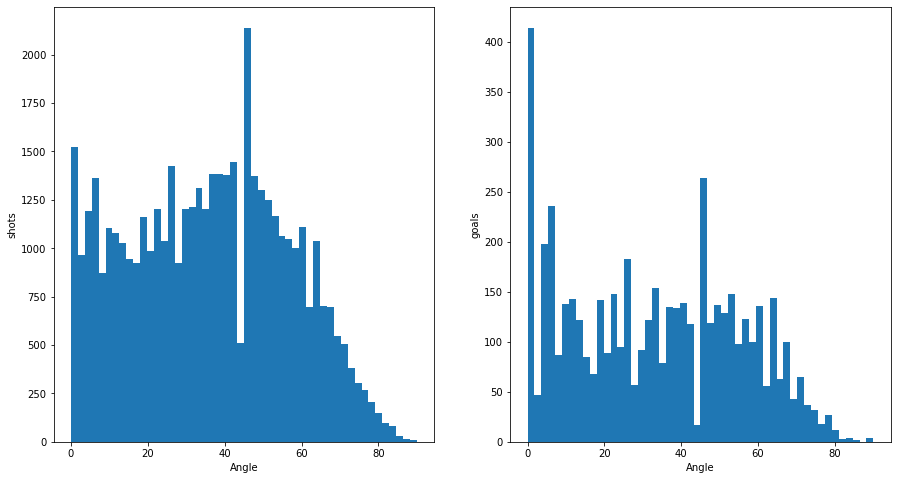

In [188]:
fig, axlist = plt.subplots(nrows=1,ncols=2, figsize = (15,8))
axlist[0].hist(x=df[df['subEventName'].isin(ev_filter)]['angle_to_goal'],bins=50)
axlist[1].hist(x=df[(df['subEventName'].isin(ev_filter)) & (df['goal']==1)]['angle_to_goal'],bins=50)
axlist[0].set_xlabel('Angle')
axlist[0].set_ylabel('shots')
axlist[1].set_xlabel('Angle')
axlist[1].set_ylabel('goals')
plt.show()

In [152]:
'''Plotly not working on labs'''

# fig = plotly.subplots.make_subplots(rows=1,cols=2)
# hist_1 = go.Histogram(x=df[df['subEventName'].isin(ev_filter)]['angle_to_goal'],name='all shots',nbinsx=50)
# hist_2 = go.Histogram(x=df[(df['subEventName'].isin(ev_filter)) & (df['goal']==1)]['angle_to_goal'], name='goals',nbinsx=50)
# fig.add_trace(hist_1,row=1,col=1)
# fig.add_trace(hist_2, row=1, col=2)
# fig.update_xaxes(title='angle to goal')
# fig.layout['yaxis'].update(title='number of shots')
# fig.show()

'Plotly not working on labs'

It's not immediately clear that the angle to goal is a massive determining factor, although it may interact with distance in some way
<a name='4'></a>
## Section 4 Analytical approach

We aren't really lookign to classify things as a goal or not, we are looking to assign a probability to a certain shot going in, and as a benchmark we can compare to a model that treats each shot as equal. This will then allows us to accurately guess the number of goals a team scored in a match.

There are 2000 matches in the sample, so a good approach would be to look at 1400 matches (training data = ~20000 shots), and create an expected goals model from that. To 'validate and test' the model, we can predict the outcome of the remaining 300(val)/300(test) matches against a) a basic model that always predicts the most common number of goals b) a model that treats all shots as equal, and uses shot count to predict goals

We effectively have 4000 samples, because each match has two teams with an individual number of goals in each match

#### First let's split the data into TVT

In [13]:
#get all the match IDs
set_of_unique_matches = tuple(set(matches_df['wyId']))

In [14]:
#split the data into train, test and val
matches_id_train_set, matches_id_val_set = train_test_split(set_of_unique_matches,test_size=0.32, random_state=r_seed)
matches_id_val_set, matches_id_test_set = train_test_split(matches_id_val_set,test_size = 0.35, random_state=r_seed)
print(f'In the three sets there are:\ntrain set: {len(matches_id_train_set)}\nval set: {len(matches_id_val_set)}\ntest set: {len(matches_id_test_set)}')

In the three sets there are:
train set: 1319
val set: 404
test set: 218


In [15]:
#this creates a df with matches for the train, val, test set separately
matches_df_train = matches_df[matches_df['wyId'].isin(matches_id_train_set)]
matches_df_val = matches_df[matches_df['wyId'].isin(matches_id_val_set)]
matches_df_test = matches_df[matches_df['wyId'].isin(matches_id_test_set)]
#split events table into the relevant sets
events_df_train = df[df['matchId'].isin(matches_id_train_set)]
events_df_val = df[df['matchId'].isin(matches_id_val_set)]
events_df_test = df[df['matchId'].isin(matches_id_test_set)]

~
### Building an xG model to give a value to each shot

for the training set, we'll take just the rows in the training dataframe where the eventName is shots. We can then apply a logistic regression model to create a model which predicts 'expected goals' based on the shot metadata, and the relevant collumns

In [16]:
events_df_train_shot_only = events_df_train[events_df_train['subEventName'].isin(ev_filter)][['subEventName','event_location_y', 'event_location_x', 'is_penalty', 'is_freekick',
       'goal', 'left_foot', 'right_foot', 'head', 'counter_attack',
       'opportunity', 'distance_to_goal',
       'angle_to_goal']]

<a name='4a'></a>
## Min Max Scaler and interaction variables

1) use min max scaler to normalised data (this will mean that the binary categories don't change)

2) create interaction variables

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
'''MinMaxScale'''

#apply to relevant columns and fit the scaler - note: i've removed left and right foot so it's either head or not.
mms = MinMaxScaler().fit(events_df_train_shot_only[['is_penalty', 'is_freekick', 'head', 'counter_attack', 'opportunity', 'distance_to_goal','angle_to_goal']])
#transform
x_train_mms = pd.DataFrame(columns=['is_penalty', 'is_freekick', 'head', 'counter_attack','opportunity', 'distance_to_goal','angle_to_goal'],data=mms.transform(events_df_train_shot_only[['is_penalty', 'is_freekick', 'head', 'counter_attack','opportunity', 'distance_to_goal','angle_to_goal']]))

'''Create polynomial features'''

cols_for_poly = ['is_freekick',  'head', 'counter_attack','opportunity']
second_cols_for_poly = ['distance_to_goal','angle_to_goal']
#first apply the first col * second col
for col in cols_for_poly:
    for second_col in second_cols_for_poly:
        x_train_mms[f'{col}X{second_col}'] = x_train_mms[col] * x_train_mms[second_col]
#then square the second cols
for col in second_cols_for_poly:
    x_train_mms[f'{col}^2'] = x_train_mms[col]**2
#then multiply the last two cols together
x_train_mms[f'distXangle'] = x_train_mms['distance_to_goal'] * x_train_mms['angle_to_goal']


<a name='4b'></a>
## Logistic Regression 1: Logit 

We will use a Logit model in order to get probability of a certain shot being a goal

In [19]:
y = events_df_train_shot_only['goal'].reset_index().drop(columns='index')
x_logit = sm.add_constant(x_train_mms)

In [20]:
logit_model_basic = sm.Logit(y,x_logit).fit()
print(logit_model_basic.summary())

Optimization terminated successfully.
         Current function value: 0.265569
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                   goal   No. Observations:                31396
Model:                          Logit   Df Residuals:                    31377
Method:                           MLE   Df Model:                           18
Date:                Fri, 11 Jun 2021   Pseudo R-squ.:                  0.2372
Time:                        17:42:37   Log-Likelihood:                -8337.8
converged:                       True   LL-Null:                       -10930.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -2.6595      0.443     -6.001 

Drop some columns that don't add value

In [21]:
#Lets drop the columns that aren't adding anything
x_logit_reduc = x_logit.drop(columns=['is_freekick','is_freekickXangle_to_goal','counter_attackXdistance_to_goal', 'counter_attackXangle_to_goal',
       'opportunityXdistance_to_goal', 'opportunityXangle_to_goal','distXangle'])

In [22]:
#Let's add regularization too
logit_model_basic_reduc = sm.Logit(y,x_logit_reduc).fit_regularized(method='l1',alpha=1)
print(logit_model_basic_reduc.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2676129633300983
            Iterations: 275
            Function evaluations: 275
            Gradient evaluations: 275
                           Logit Regression Results                           
Dep. Variable:                   goal   No. Observations:                31396
Model:                          Logit   Df Residuals:                    31386
Method:                           MLE   Df Model:                            9
Date:                Fri, 11 Jun 2021   Pseudo R-squ.:                  0.2360
Time:                        17:42:40   Log-Likelihood:                -8350.3
converged:                       True   LL-Null:                       -10930.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

#####

<a name='4c'></a>
## ROC-AUC curve

Train Set ROC-AUC


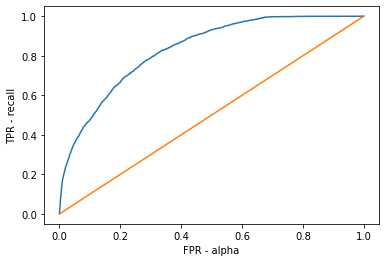

AUC score: 0.8315651035207395


In [23]:
from sklearn.metrics import roc_curve, auc
def roc_auc_(y, logit_model_basic_reduc, x_logit_reduc,curve='yes',proba='no'):
    if proba == 'no':
        fpr, tpr, threshold = roc_curve(y, logit_model_basic_reduc.predict(x_logit_reduc))
    else:
        fpr, tpr, threshold = roc_curve(y, logit_model_basic_reduc.predict_proba(x_logit_reduc)[:,1])
    if curve == 'yes':
        plt.plot(fpr,tpr)
        plt.plot(np.linspace(0,1,50),np.linspace(0,1,50))
        plt.xlabel('FPR - alpha')
        plt.ylabel('TPR - recall')
        plt.show()
    print(f'AUC score: {auc(fpr,tpr)}')
    return auc(fpr,tpr)
print('Train Set ROC-AUC')
auc_train_logit = roc_auc_(y, logit_model_basic_reduc, x_logit_reduc,curve='yes')

## This is the ROC-AUC curve for train data

~

Validation data - we'll create a function which performs the necessary scaling etc, to get the x data in the right format

Validation set AUC


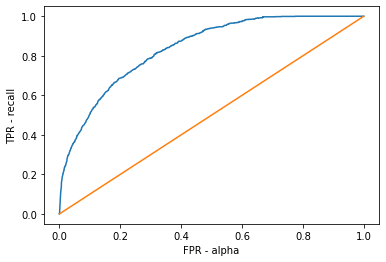

AUC score: 0.8382463922130328


In [24]:
val_shots_only = events_df_val[events_df_val['subEventName'].isin(ev_filter)]
df_ = val_shots_only[['is_penalty', 'is_freekick', 'head', 'counter_attack', 'opportunity', 'distance_to_goal','angle_to_goal']]
y_val = val_shots_only['goal'].drop(columns='index')
def transform_data_for_logit(df_):
    x_mms = pd.DataFrame(columns=df_.columns,data=mms.transform(df_))
    x_mms['is_freekickXdistnace_to_goal'] = x_mms['is_freekick']*x_mms['distance_to_goal']
    x_mms['headXdistance_to_goal'] = x_mms['head']*x_mms['distance_to_goal']
    x_mms['headXangle_to_goal'] = x_mms['head']*x_mms['angle_to_goal']
    x_mms['distance_to_goal^2'] = x_mms['distance_to_goal'] **2
    x_mms['angle_to_goal^2'] = x_mms['angle_to_goal'] ** 2
    x_mms.drop(columns='is_freekick',inplace=True)
    x_mms_k = sm.add_constant(x_mms,has_constant='add')
    return x_mms_k
print("Validation set AUC")
x_val_roc_ = transform_data_for_logit(df_)
auc_val_logit = roc_auc_(y_val, logit_model_basic_reduc, x_val_roc_, curve='yes')


#### Excellent! It also doesn't appear to be overfit at all. 

We're able to predict whether or not a goal would be scored from a given shot with significantly more accuracy than taking every shot as equal

This model has a lot of intuitive sense. 

For example, penalty and 'opportunity' increase the expected goal percentage, whereas the value of the shot decreases with the distance to the goal.

We now need to create a method to use this to predict individual games, by summing up the value of expected goals a team has in one game. Note: again, this may not be the best method and we will come back to this

<a name='4d'></a>
## Let's compare performance to Decision tree model

We will train on the training data and then use the validation data for assessing performance

In [162]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
list_auc_scores_DTs = []
max_nodes = [13,21,29,37,45]
print(f'Decision Tree evaluation:\n')
for nodes in max_nodes:
    print(f'max nodes: {nodes}')
    dtc = DecisionTreeClassifier(max_leaf_nodes=nodes)
    dtc.fit(x_logit_reduc, y)
    auc_dtc = roc_auc_(y_val, dtc, x_val_roc_,curve='no',proba='yes')
    list_auc_scores_DTs.append(auc_dtc)

Decision Tree evaluation:

max nodes: 13
AUC score: 0.816883745596109
max nodes: 21
AUC score: 0.8277103161874876
max nodes: 29
AUC score: 0.8302070302385997
max nodes: 37
AUC score: 0.8311456800466706
max nodes: 45
AUC score: 0.8303032674209818


#### Performance doesn't really increase after 29 nodes, so we will use that. Lets look at the AUC curve

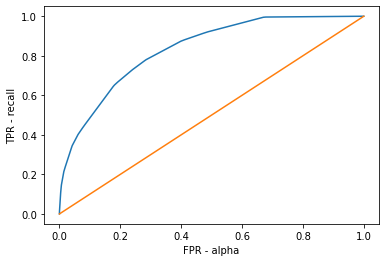

AUC score: 0.832908767425292


In [164]:
auc_dtc_train = roc_auc_(y, dt_best, x_logit_reduc,curve='yes',proba='yes')

Here are the top couple of layers, showing that there is quite a wide range of variables being used


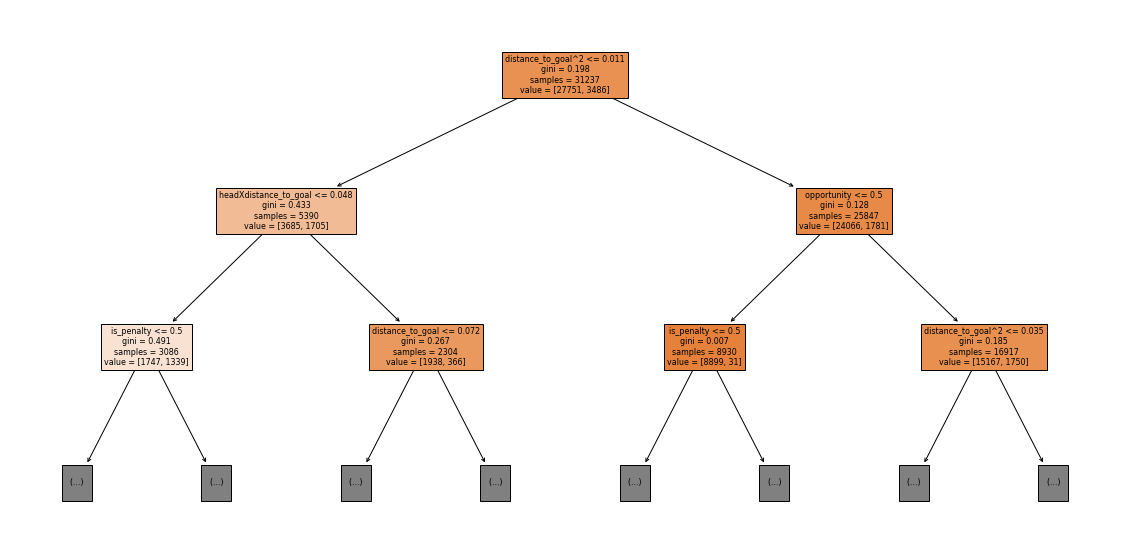

In [163]:
fig = plt.figure(figsize=(20,10))
dt_best = DecisionTreeClassifier(max_leaf_nodes=29).fit(x_logit_reduc,y)
print(f'Here are the top couple of layers, showing that there is quite a wide range of variables being used')
fig = plot_tree(dt_best,feature_names = x_val_roc_.columns,max_depth=2,filled=True)
plt.show()

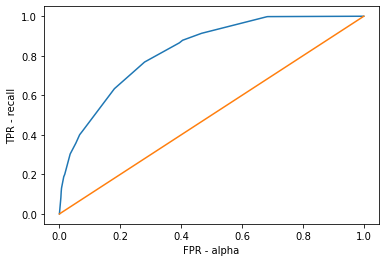

AUC score: 0.8277103161874876


In [45]:
auc_dtc = roc_auc_(y_val, dt_best, x_val_roc_,curve='yes',proba='yes')

Overall, we seem to achieve a ~0.83 AUC score on decision tree and logistic regression. This tells us we can achieve a significantly higher amount of predictive power than by treating all shots equally.

<a '4g' ><a>
### Random forest and stacking

We will see if we can beat the DecisionTreeClassifier by implementing a Random Forest

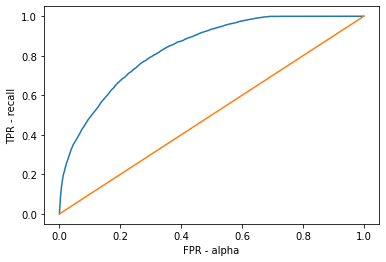

AUC score: 0.8348519153747764


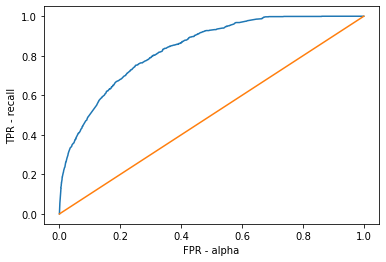

AUC score: 0.8367427554770652


0.8367427554770652

In [52]:
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier(n_estimators=80, max_depth=5, max_samples = 0.5, max_features=10) #
randomForest.fit(x_logit_reduc, y) # fit random forest of decision trees
#visualise_predictions(randomForest.predict, x_logit, y) # visualise
roc_auc_(y,randomForest, x_logit_reduc,curve='yes',proba='yes')
roc_auc_(y_val,randomForest, x_val_roc_,curve='yes',proba='yes')

##### Better performance with the RF than basic decision tree, but still worse than Logit

<a name='4e'></a>
### Stacking

I'll try a slightly novel approach for stacking, which is to build an additional NN model for the initial problem. I will then use a 2 hideden layer NN to add the outputs of each of the models to the input features, to see if there is a relationship between which model it should use dependent on the X inputs.

We need to create a further TT split so that we have data to train the meta model on.

In [46]:
stack_x_train, stack_x_test, stack_y_train, stack_y_test = train_test_split(x_logit_reduc, y, test_size = 0.4, random_state = r_seed)

In [58]:
stack_x_train.shape

(18837, 12)

In [70]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [54]:
#create logit model
logit_model_forstack = sm.Logit(stack_y_train, stack_x_train).fit()
#create Ridge model
RF_forstack = RandomForestClassifier(max_depth = 5, max_features = 10, n_estimators = 80).fit(stack_x_train, stack_y_train)

Optimization terminated successfully.
         Current function value: 0.268339
         Iterations 10


In [72]:
model_stack = Sequential()
model_stack.add(Dense(30, input_shape=(12,),kernel_regularizer = 'l2', bias_regularizer = 'l1',activation='relu'))
model_stack.add(Dense(30,kernel_regularizer='l2', bias_regularizer='l2',activation='relu'))
model_stack.add(Dense(1,activation='sigmoid'))
model_stack.compile(optimizer='rmsprop',metrics='acc',loss='binary_crossentropy')

In [73]:
model_stack.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 30)                390       
_________________________________________________________________
dense_15 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 31        
Total params: 1,351
Trainable params: 1,351
Non-trainable params: 0
_________________________________________________________________


In [76]:
model_stack.fit(x=stack_x_train, y =stack_y_train, batch_size=50, epochs=5,validation_split = 0.1)

Epoch 1/5
340/340 [==============================] - 0s 1ms/step - loss: 0.3035 - acc: 0.8921 - val_loss: 0.2754 - val_acc: 0.9082
Epoch 2/5
340/340 [==============================] - 0s 1ms/step - loss: 0.3029 - acc: 0.8921 - val_loss: 0.3048 - val_acc: 0.9114
Epoch 3/5
340/340 [==============================] - 0s 1ms/step - loss: 0.3025 - acc: 0.8921 - val_loss: 0.2760 - val_acc: 0.9076
Epoch 4/5
340/340 [==============================] - 0s 1ms/step - loss: 0.3025 - acc: 0.8921 - val_loss: 0.2731 - val_acc: 0.9082
Epoch 5/5
340/340 [==============================] - 0s 1ms/step - loss: 0.3016 - acc: 0.8922 - val_loss: 0.2731 - val_acc: 0.9082


##### OK, that model on its own actually has a 91% validation accuracy but this isn't a comparable metric to AUC / ROC

For now, let's press ahead with the Stacking model

So, we have 4 models. Logit, RF, Ridge and NN. We will now include the predictions of these models as 'X' values for the stack_x_test dataset (hence increasing the number of variables to 16 from 12), and then put that in a neural network.

In [124]:
def run_stack_models_and_combine_with_x(stack_x_test, stack_y_test):
    predictions_stack_logit = pd.DataFrame(logit_model_forstack.predict(stack_x_test),columns=['logit']).reset_index().drop(columns='index')
    predictions_stack_RF = pd.DataFrame(RF_forstack.predict_proba(stack_x_test)[:,1],columns=['RF']).reset_index().drop(columns='index')
    predictions_stack_NN = pd.DataFrame(model_stack.predict_proba(stack_x_test),columns=['NN']).reset_index().drop(columns='index')
    amp = pd.merge(predictions_stack_logit, predictions_stack_RF,left_index = True,right_index = True)
    preds_stack_test =pd.merge(amp, predictions_stack_NN, left_index=True, right_index=True)
    stack_x_test_combined = pd.merge(stack_x_test.reset_index().drop(columns='index'),preds_stack_test,left_index=True, right_index=True)
    stack_y_test_drop_ind = stack_y_test.reset_index().drop(columns='index')
    
    return stack_x_test_combined, stack_y_test_drop_ind
stack_x_test_combined, stack_y_test_drop_ind = run_stack_models_and_combine_with_x(stack_x_test, stack_y_test)

In [121]:
model_stack_meta = Sequential()
model_stack_meta.add(Dense(30, input_shape=(15,),kernel_regularizer = 'l2', bias_regularizer = 'l1',activation='relu'))
model_stack_meta.add(Dense(30,kernel_regularizer='l2', bias_regularizer='l2',activation='relu'))
model_stack_meta.add(Dense(1,activation='sigmoid'))
model_stack_meta.compile(optimizer='rmsprop',metrics='acc',loss='binary_crossentropy')

In [123]:
model_stack_meta.fit(stack_x_test_combined, stack_y_test_drop_ind,batch_size = 30, epochs = 10,validation_split=0.1)

Epoch 1/10
377/377 [==============================] - 0s 1ms/step - loss: 0.2994 - acc: 0.9006 - val_loss: 0.2818 - val_acc: 0.9108
Epoch 2/10
377/377 [==============================] - 0s 1ms/step - loss: 0.2964 - acc: 0.9005 - val_loss: 0.2824 - val_acc: 0.9116
Epoch 3/10
377/377 [==============================] - 0s 1ms/step - loss: 0.2945 - acc: 0.9011 - val_loss: 0.2813 - val_acc: 0.9092
Epoch 4/10
377/377 [==============================] - 0s 1ms/step - loss: 0.2929 - acc: 0.9011 - val_loss: 0.2760 - val_acc: 0.9108
Epoch 5/10
377/377 [==============================] - 0s 1ms/step - loss: 0.2911 - acc: 0.9003 - val_loss: 0.2746 - val_acc: 0.9092
Epoch 6/10
377/377 [==============================] - 0s 1ms/step - loss: 0.2902 - acc: 0.9001 - val_loss: 0.2771 - val_acc: 0.9084
Epoch 7/10
377/377 [==============================] - 0s 1ms/step - loss: 0.2892 - acc: 0.9000 - val_loss: 0.2731 - val_acc: 0.9092
Epoch 8/10
377/377 [==============================] - 0s 1ms/step - loss: 0.

#### To test this on the validation set, we need to run the 3 models on the validation set, and then run the meta model on the validation set

##### Our key metric is ROC AUC, so we will have a look to see if we can beat the previous scores

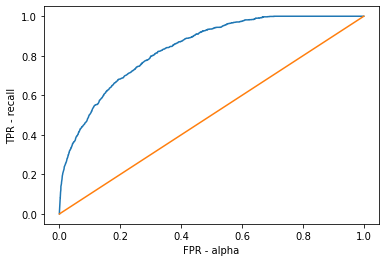

AUC score: 0.8383101655768723


0.8383101655768723

In [128]:
val_x_comb, val_y_comb = run_stack_models_and_combine_with_x(x_val_roc_, y_val)
roc_auc_(val_y_comb, model_stack_meta, val_x_comb, curve='yes', proba='no')

#### Same as the Logistic Regression we started with!

In general, we want models that are interpretable over those that are not. The Stacking model is complex, and gives us no increase in performance. As a result, we will now definitelyve choose the Logistic Regression as the best model for this problem

<a name='4f'></a>
#### Choosing a threshold

Given it's slightly higher value in the validation arena, we will use the logit model. It's also slightly more interpretable.

It's difficult to choose a specific value for the relative cost of type 1 and 2 errors. However, the relative cost of a false positive is significantly lower. Roughly 2% of plays end in a goal, so the cost of shooting and losing the ball can be estimated at ~2% (the chance the other team goes on to score + the chance you forewent in passing to team mate, which is higher than 2% because you conceivably were in a good position). The prevalence in the dataset of goals is 0.112 (evidence in section 4), which gives an m value of 0.317.

So, in order to find the optimum threshold we can optimise the function

fm = TPR - 0.317 FPR

In [222]:
m = ((1-0.112)/0.112) * (0.05/1) 
print(f'M value is: {round(m,3)}')
fpr, tpr, threshold = roc_curve(y_val, logit_model_basic_reduc.predict(x_val_roc_))
fm = tpr - m*fpr
fm_maxidx = np.argmax(fm)
print(f'\nBest model therefore has the following values \n\nThreshold: {round(threshold[fm_maxidx],4)} \nTPR: {round(tpr[fm_maxidx],2)} \nFPR: {round(fpr[fm_maxidx],2)}')
print(f'Fm value: {round(fm[fm_maxidx],3)}')

M value is: 0.396

Best model therefore has the following values 

Threshold: 0.0586 
TPR: 0.94 
FPR: 0.51
Fm value: 0.737


<a name='4g'></a>
### Running data on Test Set

Now we have our chosen model and threshold we can re-run the data on the test set

##### Let's run the AUC-ROC curve first

Test set AUC


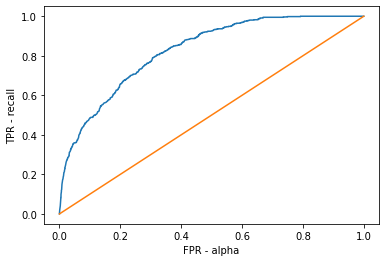

AUC score: 0.8263974155664164


In [223]:
test_shots_only = events_df_test[events_df_test['subEventName'].isin(ev_filter)]
df_test = test_shots_only[['is_penalty', 'is_freekick', 'head', 'counter_attack', 'opportunity', 'distance_to_goal','angle_to_goal']]
y_test = test_shots_only['goal'].drop(columns='index')
print("Test set AUC")
x_test_roc_ = transform_data_for_logit(df_test)
auc_test_logit = roc_auc_(y_test, logit_model_basic_reduc, x_test_roc_, curve='yes')


#### Now let's calculate the FPR, TPR and Fm score at our threshold values

In [249]:
fpr_test, tpr_test, threshold_test = roc_curve(y_test, logit_model_basic_reduc.predict(x_test_roc_))
#create predictions
test_set_size = len(y_test)
preds = np.where(logit_model_basic_reduc.predict(x_test_roc_)>threshold[fm_maxidx],1,0)
FPR = np.sum(np.where(preds>y_test,1,0)) / np.sum(np.where(y_test == 0,1,0))
TPR = np.sum(np.where((preds==1) & (y_test==1),1,0))/ np.sum(np.where(y_test==1,1,0))
fm_score = TPR - m*FPR

pd.DataFrame(data=[[FPR,TPR,fm_score]],columns = ['fpr', 'tpr', 'fm_score'])


,fpr,tpr,fm_score
0,0.500323,0.925926,0.727584


### Great ! Our Data performances very similarly on the test set! 

Conclusion: we have a model which has significantly more power at predicting the value of a shot than the base case.

Because the cost of a FN is so much higher than the cost of a FP, we have set our threshold at 0.0586: if there is a 5.86% chance of a goal, the player should shoot from this position! This advice would obviously depend on the coach's perception of how likely the play was to result in a better shooting opportunity



~~~~~~~

<a name='5'></a>
## Section Five - Can we use this to predict the way a match is most likely to go

This is impact because goals are rare, and therefore judging a team on scores alone only makes sense with a huge sample. If we can find the leading indicators that tend, over time, to lead to good performance, this has an impact on coach's ability to analyse the games.

Initially, let's get a baseline for predictions, based on simply predicting the most likely score.



In [46]:
display(pd.DataFrame(matches_df['home_team_score'].value_counts(normalize=True).sort_values(ascending=False).head(2)))
pd.DataFrame(matches_df['away_team_score'].value_counts(normalize=True).sort_values(ascending=False).head(2))

,home_team_score
1,0.316332
0,0.246265


,away_team_score
1,0.350850
0,0.328181


## So by predicting the team to score 1 goal, we would be correct around 33.2% of the time (blended home and away)

<a name='5a'></a>
## Basic Shots model for comparison

Now let's create a model which looks at the number of shots a team has, assigns a homogenous value to each shot, in order to predict the number of goals a team will score in a match

The "Model" here will be simply to find out how how many goals there were, and how many shots there were, divide one by the other, to get the average value of 'a shot'

In [47]:
goals_train_set = len(events_df_train[(events_df_train['goal']==1) & (events_df_train['subEventName'].isin(ev_filter))])
shots_train_set = len(events_df_train[(events_df_train['subEventName'].isin(ev_filter))])
conversion = round(goals_train_set / shots_train_set,3)
print(f'There were {goals_train_set} goals\nThere were {shots_train_set} shots\nSo each shot is worth {conversion} of a gaol')

There were 3486 goals
There were 31237 shots
So each shot is worth 0.112 of a gaol


### Judging performance

We will judge relative performance of the shot and more advanced models in 3 ways:

1) Let's take squared difference between actual goals and xG

2) let's take squared difference between actual goals and rounded xG

3) What % of scores are they able to accurately predict - note: summing xG in a match may not be the absolutely best way to use the xG model, because it will result in the mean goals scored, as opposed to the max. likelihood. We'll return to this later

In [48]:
#create an xG for each shot in the events table
events_df_val['xG'] = events_df_val['subEventName'].apply(lambda x: conversion if x in (ev_filter) else 0)
events_df_train['xG'] = events_df_train['subEventName'].apply(lambda x: conversion if x in (ev_filter) else 0)

In [49]:
'''This function takes a table with xGs by event, and creates a performance metric table'''

#helper- create a function that gets the score from the matches table
def get_score(matchId, teamId):
    return (matches_df[(matches_df['wyId'] == matchId)]['teamsData']).item()[teamId]['score']
    
def judge_performance(events_df_val,column_name):
    
    #group by match and id
    goals_predictions_table_shot_model = events_df_val.groupby(by=['matchId','teamId'])[[column_name]].sum().reset_index()
    #create blank column for us to fill in
    goals_predictions_table_shot_model['actual_goals'] = ''
    location_of_target_column = (goals_predictions_table_shot_model.columns).get_loc('actual_goals') 
    
    #get the scores for all the matchesin the new table we created
    goals_predictions_table_shot_model['actual_goals'] = goals_predictions_table_shot_model.apply(lambda x: get_score(x.matchId,str(x.teamId)),axis=1)
    #create a rounded xG metric
    goals_predictions_table_shot_model['rounded_xG'] = goals_predictions_table_shot_model[column_name].apply(lambda x: round(x,0))
    
    #create two error metrics
    squared_error_shots_model = np.sum((goals_predictions_table_shot_model[column_name] - goals_predictions_table_shot_model['actual_goals'])**2) / len(goals_predictions_table_shot_model)
    rounded_squared_error_shots_model = np.sum((goals_predictions_table_shot_model['rounded_xG'] - goals_predictions_table_shot_model['actual_goals'])**2) / len(goals_predictions_table_shot_model)
    correct_predictions = f'{100*round(np.sum(goals_predictions_table_shot_model["rounded_xG"] == goals_predictions_table_shot_model["actual_goals"]) / len(goals_predictions_table_shot_model),3)}%'
    print(f'Average squared error of model: {squared_error_shots_model}\nAverage rounded squared error shots model: {rounded_squared_error_shots_model}\nCorrect scores: {correct_predictions}')
    return goals_predictions_table_shot_model, squared_error_shots_model, rounded_squared_error_shots_model, correct_predictions

print("Training set:")
basic_model_train, basic_mod_sqerr_train, basic_model_roundsqerr_train, correct_predictions_basic_model_train = judge_performance(events_df_train,'xG')
print("Validation set:")
basic_model_table, basic_model_sqerr,basic_model_round_sqerr, correct_predictions =judge_performance(events_df_val,'xG')

Training set:
Average squared error of model: 1.4594970007581503
Average rounded squared error shots model: 1.5223654283548143
Correct scores: 34.0%
Validation set:
Average squared error of model: 1.4265194455445545
Average rounded squared error shots model: 1.5173267326732673
Correct scores: 31.4%




## So now let's use the xG model on the train and val set

Let's try it on the training data and the validation data, to check for overfitting. Although we can only use it on the validation set to compare with the shots model

In [50]:
def predict_xG(is_penalty, is_freekick, head, counter_attack, opportunity, distance_to_goal, angle_to_goal,logit_model):
    columns=['is_penalty', 'is_freekick', 'head', 'counter_attack', 'opportunity', 'distance_to_goal','angle_to_goal']
    df_ = pd.DataFrame([[is_penalty, is_freekick, head, counter_attack, opportunity, distance_to_goal,angle_to_goal]],columns=columns)
    x_mms = pd.DataFrame(columns=columns,data=mms.transform(df_))
    x_mms['is_freekickXdistnace_to_goal'] = is_freekick*x_mms['distance_to_goal']
    x_mms['headXdistance_to_goal'] = head*x_mms['distance_to_goal']
    x_mms['headXangle_to_goal'] = head*x_mms['angle_to_goal']
    x_mms['distance_to_goal^2'] = x_mms['distance_to_goal'] **2
    x_mms['angle_to_goal^2'] = x_mms['angle_to_goal'] ** 2
    x_mms.drop(columns='is_freekick',inplace=True)
    x_mms_k = sm.add_constant(x_mms,has_constant='add')
    return logit_model.predict(x_mms_k)

In [154]:
##Here's one i made earlier, which has the function above applied to it
with open('saved_dfs/events_with_xg_logit_applied_train','w') as f:
    events_df_train.to_csv(f)
with open('saved_dfs/events_with_xg_logit_applied_val','w') as f:
    events_df_val.to_csv(f)

In [51]:
'''Doesnt need to be ran, as we can load from above'''
#create an xG for each shot in the events table
# events_df_train['xG_logit'] = events_df_train.apply(lambda x: predict_xG(x.is_penalty,x.is_freekick,x['head'],x.counter_attack, x.opportunity, x.distance_to_goal, x.angle_to_goal,logit_model_basic_reduc) if x.subEventName in ev_filter else 0, axis=1)

In [52]:
logit_model_perf_table_train, logit_model_sqerr_train, logit_model_rounded_sqerr_train, correct_predictions_train = judge_performance(events_df_train,'xG_logit')

Average squared error of model: 1.1542759919909067
Average rounded squared error shots model: 1.2748294162244125
Correct scores: 40.699999999999996%


In [53]:
'''Doesnt need to be ran, as we can load from above'''
#create an xG for each shot in the events table
# events_df_val['xG_logit'] = events_df_val.apply(lambda x: predict_xG(x.is_penalty,x.is_freekick,x['head'],x.counter_attack, x.opportunity, x.distance_to_goal, x.angle_to_goal,logit_model_basic_reduc) if x.subEventName in ev_filter else 0, axis=1)


In [54]:
#group by match and id
logit_model_perf_table, logit_model_sqerr, logit_model_rounded_sqerr, correct_predictions = judge_performance(events_df_val,'xG_logit')

Average squared error of model: 1.2310572821329222
Average rounded squared error shots model: 1.306930693069307
Correct scores: 37.6%


#### Success! We have significantly lower squared error of model than we did before and have beaten the base model of 33%



We did better on the training data (although not by that much), so we may have a slight problem with overfitting, although it is within acceptable bounds

### Moving away from using the mean as a predictor

Up until now, we have predicted the number of goals a team will score by using the sum of xG. This is likely to produce the best score in terms of 'average squared error' but may be worse at predicting individual match outcomes. We may be better off using a max. likelihood model, such as logistic regression or decision tree, to predict the score.

We may also want to include additional metrics, such as shot count and summed variance of the Xg (for example: two 0.5 xg shots are very different to 1 0.9 xG shot and a 0.1 xG shot). We will use the variance formula: 
var(allshots) = ∑var(shot) so we have the mean and variance of a teams goals in a match. We will then apply this to various classifier models

In [55]:
#create a function for generating the variance
def var_function(x):
    return np.sum([x*(1-x) for x in x])

#create a table with variance, xG and shots
def create_xg_and_shot_df(events_df_val):
#create a col with a 1 in it if theres a shot
    events_df_val['shot'] = events_df_val['subEventName'].apply(lambda x: 1 if x in (ev_filter) else 0)

    #apply aggregator function to shot and xg model, and drop the variance of shots
    multi_facet_model_val = events_df_val.groupby(
                        by=['matchId','teamId'])[['xG_logit','shot']].agg([lambda x: var_function(x),'sum']).drop(columns=[('shot','<lambda_0>')])
    #remove the multi-levelling
    multi_facet_model_val[['variance','xg','shots']] = multi_facet_model_val[[('xG_logit', '<lambda_0>'),('xG_logit','sum'),('shot','sum')]]
    multi_facet_model_val = multi_facet_model_val[['variance','xg','shots']].reset_index()

    #create blank column for us to fill in
    multi_facet_model_val['actual_goals'] = ''
    loc_target = multi_facet_model_val.columns.get_loc(('actual_goals', '')) 
    #get the scores for all the matchesin the new table we created - we have to use a different method because we've got these weird columns
    for row in range(len(multi_facet_model_val)):
        multi_facet_model_val.iloc[row,int(loc_target)] = get_score(multi_facet_model_val.iloc[row,0],str(multi_facet_model_val.iloc[row,1]))
    return multi_facet_model_val
xg_shot_var_model_val = create_xg_and_shot_df(events_df_val)        

In [56]:
xg_shot_var_model_train = create_xg_and_shot_df(events_df_train)

~
### Data preparation

We will attempt a classifier as well as regression.

Note: the sklearn functions don't take one hot encoding

In [59]:
y_train_multi_face = xg_shot_var_model_train['actual_goals']
y_val_multi_face = xg_shot_var_model_val['actual_goals']

In [60]:
#now get the x's sorted
x_train_multi_face = xg_shot_var_model_train[[
                                              (    'variance', ''),
                                                (          'xg', ''),
                                                (       'shots', '')]]
x_val_multi_face = xg_shot_var_model_val[[(         'variance', ''),
                                                (          'xg', ''),
                                                (       'shots', '')]]

#### The Y variable here will be very skewed, positively. There's a few options we could employ

1) Take a log of the Y variable

2) Use a sigmoid and run it as a classification

3) Try polynomial features in a regression analysis

4) Try decision tree, which may capture the non linearity of how the variables relate to each other

5) Take an analytical approach, using binomial theory to calculate the chance of 1 / 2 /3 goals based on the probability of each shot

One thing to mention is that number of shots, and variance will effectively decrease the accuracy of the xG model. The variables are also definitely correlated

In [61]:
print(f'Skew of the Y value is {xg_shot_var_model_train["actual_goals"].skew()}')


Skew of the Y value is 1.1098391683343996


In [62]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score

In [73]:
np.random_seed = 1

<a name='5b'></a>

### Linear Regression

In [74]:
#train model
lin_reg = LinearRegression().fit(x_train_multi_face,y_train_multi_face)
#predict train set
def predict_model_cheat(lin_reg,x_train_multi_face, y_train_multi_face, x_val_multi_face, y_val_multi_face):
    lin_reg_train_predictions = lin_reg.predict(x_train_multi_face)
    lin_reg_train_rounded_scores = np.round(lin_reg_train_predictions)
    lin_reg_val_predictions = lin_reg.predict(x_val_multi_face)
    lin_reg_val_rounded_scores = np.round(lin_reg_val_predictions)
    display(f'Correct Predictions {100*round(np.sum(lin_reg_val_rounded_scores==y_val_multi_face) / len(y_val_multi_face),3)}% of the time on val')
    display(f'Correct Predictions {100*round(np.sum(lin_reg_train_rounded_scores==y_train_multi_face) / len(y_train_multi_face),3)}% of the time on train')
    return lin_reg_val_rounded_scores
lin_reg_val_rounded_scores = predict_model_cheat(lin_reg,x_train_multi_face, y_train_multi_face, x_val_multi_face, y_val_multi_face)

'Correct Predictions 36.1% of the time on val'

'Correct Predictions 39.6% of the time on train'

We're overfitting a bit - Let's see the coefficients. We'l come back and do a Lasso if we can't get better than this with another model

In [75]:
display(pd.DataFrame(data=lin_reg.coef_.reshape(1,-1), columns= [x[0] for x in x_train_multi_face.columns]))

,variance,xg,shots
0,0.706346,0.631778,-0.046399


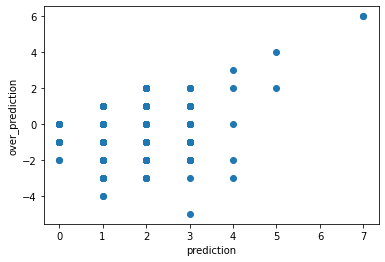

In [76]:
#plot errors - they seem
errors = lin_reg_val_rounded_scores - y_val_multi_face
plt.scatter(lin_reg_val_rounded_scores,errors)
plt.ylabel('over_prediction')
plt.xlabel('prediction')
plt.show()

<a name='5c'></a>

# Classification

### Logistic Regression

In [77]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(penalty='none',multi_class='multinomial')
log_model.fit(x_train_multi_face,y_train_multi_face.astype('category'))
rounded_scores_log_res = predict_model_cheat(log_model,x_train_multi_face, y_train_multi_face, x_val_multi_face, y_val_multi_face)

'Correct Predictions 41.099999999999994% of the time on val'

'Correct Predictions 41.5% of the time on train'

#### Amazing! Much, much better :-)

It's worth noting that our validation set is only 404 samples, so this difference is 20 over 150. Let's try Ridge

In [78]:
from sklearn.linear_model import RidgeClassifier
ridge_array = np.zeros(50,)
ridge_alpha = np.geomspace(0.001,10,50)
for idx, alpha in enumerate(ridge_alpha):
    val_preds = RidgeClassifier(alpha=alpha).fit(x_train_multi_face,y_train_multi_face.astype('category')).predict(x_val_multi_face)
    score = np.sum(val_preds==y_val_multi_face) / len(y_val_multi_face)
    ridge_array[idx] = score
pd.DataFrame(data=ridge_array.reshape(-1,1),index=ridge_alpha).sort_values(by=0,ascending=False).head(10).T

,0.109854,0.075431,0.132571,0.159986,0.193070,0.232995,0.281177,0.339322,0.409492,0.494171
0,0.424505,0.424505,0.424505,0.424505,0.424505,0.424505,0.424505,0.424505,0.424505,0.424505


#### Even better with some

<a name='5d'></a>

### Finally let's try KNN

In [80]:
from sklearn.neighbors import KNeighborsClassifier

In [81]:
nns = [1,3,5,7,9]
knn_scores = np.zeros(len(nns),)
for idx, alpha in enumerate(nns):
    knn_preds = KNeighborsClassifier(n_neighbors=alpha).fit(x_train_multi_face,y_train_multi_face.astype('category')).predict(x_val_multi_face)
    knn_score = np.sum(knn_preds==y_val_multi_face) / len(y_val_multi_face)
    knn_scores[idx] = knn_score
pd.DataFrame(data=knn_scores.reshape(-1,1),index=nns).sort_values(by=0,ascending=False).T

,9,7,5,3,1
0,0.403465,0.39604,0.378713,0.345297,0.330446


##### KNN makes it slightly worse


<a name='5e'></a>

### Bayes approach

Analytically, it would appear the best solution is to calculate the % chance of any individual number of goals based on the individual probabilities of each shot. For example, the chance of 0 goals is the product of (1-p) for all shots. The chance of 1 goal is similarly derived, looping over all shots and summing the probability that one shot went in, and the rest didn't. etc.

In [82]:
#Create val and train sets with match id, team id and a list of xGs 
xg_listed_val = events_df_val.groupby(by = ['matchId','teamId'])[['xG_logit']].agg(lambda x: [float(y) for y in x])
xg_listed_train = events_df_train.groupby(by = ['matchId','teamId'])[['xG_logit']].agg(lambda x: [float(y) for y in x])
xg_listed_train['clean'] = ''
xg_listed_val['clean'] = ''

#create a cleaned version of this without 0s
def clean_xg_list(xg_listed):
    counter = 0
    for row in xg_listed.iterrows():
        array_test =  row[1].values[0]
        xg_listed.iloc[counter,1] = [x for x in array_test if x!= 0]
        counter+=1
clean_xg_list(xg_listed_val)
clean_xg_list(xg_listed_train)

#### Create function to create percentages for each score

In [93]:
from math import factorial
def prod_of_shots_complement(x: list):
    return np.product([1-x for x in x])

def QF(shot):
    return shot / (1-shot)

def check_0_goals(x: list):
    return prod_of_shots_complement(x)

def check_1_goal(x: list):
    running_total = 0
    for shot in x:
        running_total += QF(shot) * prod_of_shots_complement(x)
    return running_total

def check_2_goal(x: list):
    running_total = 0
    for shot in x:
        for shot2 in x:
            if shot2!=shot:
                running_total += np.multiply(QF(shot),QF(shot2)) * prod_of_shots_complement(x)
    return running_total / 2

def check_3_goal(x: list):
    running_total = 0
    for shot in x:
        for shot2 in x:
            if shot2 != shot:
                for shot3 in x:
                    if shot3 not in ([shot,shot2]):
                        running_total += QF(shot)*QF(shot2)*QF(shot3) * prod_of_shots_complement(x)
    return running_total / factorial(3)

def check_4_goal(x: list):
    running_total = 0
    for shot in x:
        for shot2 in x:
            if shot2 != shot:
                for shot3 in x:
                     if shot3 not in ([shot,shot2]):
                        for shot4 in x:
                            if shot4 not in ([shot,shot2,shot3]):
                                running_total += QF(shot)*QF(shot2)*QF(shot3)*QF(shot4) * prod_of_shots_complement(x)
    return running_total / factorial(4)

def check_5_goal(x: list):
    running_total = 0
    for shot in x:
        for shot2 in x:
            if shot2 != shot:
                for shot3 in x:
                     if shot3 not in ([shot,shot2]):
                        for shot4 in x:
                            if shot4 not in ([shot,shot2,shot3]):
                                for shot5 in x:
                                    if shot5 not in ([shot, shot2, shot3, shot4]):
                                        running_total += QF(shot)*QF(shot2)*QF(shot3)*QF(shot4)*QF(shot5) * prod_of_shots_complement(x)
    return running_total / factorial(5)

def check_6_goal(x: list):
    running_total = 0
    for shot in x:
        for shot2 in x:
            if shot2 != shot:
                for shot3 in x:
                     if shot3 not in ([shot,shot2]):
                        for shot4 in x:
                            if shot4 not in ([shot,shot2,shot3]):
                                for shot5 in x:
                                    if shot5 not in ([shot, shot2, shot3, shot4]):
                                        for shot6 in x:
                                            if shot6 not in ([shot, shot2, shot3, shot4, shot5]):
                                                running_total += QF(shot)*QF(shot2)*QF(shot3)*QF(shot4)*QF(shot5)*QF(shot6) * prod_of_shots_complement(x)
    return running_total / factorial(6)

def get_most_likely_score(x: list):
    #check for 0 goals being highest
    
    best_score = 0
    best_prob = check_0_goals(x)
    #end early if 0 goals is more than 50% likely
    if best_prob > 0.5:
        return best_score, best_prob
    else:
        #now define a loop to walk through
        def one_loop(best_score, best_prob, func):
        #set 1 goal to temp prob
            temp_prob = func(x)
        #if 1 goal is less likely than 0 goals, return 0
            if temp_prob < best_prob:
                end_flag=True
                return best_score, best_prob, end_flag
            else:
                best_prob = temp_prob
                best_score = best_score+1
                if best_score == 6:
                    end_flag == True
                else:
                    end_flag = False
                return best_score, best_prob, end_flag
        
        for func in [1,2,3,4,5,6]:
            function = globals()[f'check_{str(func)}_goal']
            best_score, best_prob, end_flag = one_loop(best_score, best_prob, function)
            if (end_flag == True):
                return best_score, best_prob
                break

In [140]:
#loop through each row and apply function
def apply_prob_function_to_table(xg_table):
    counter = 0
    xg_table['ML_score'] =''
    xg_table['ML_prob'] =''
    for match in xg_table.iterrows():
        one_match_data = match[1][1]
        try:
            best_score, best_prob = get_most_likely_score(one_match_data)
            xg_table.iloc[counter,2] = best_score
            xg_table.iloc[counter,3] = best_prob
        except:
            print(counter, one_match_data)
        counter+=1

In [155]:
'''to get the tbales run this, theyre saved'''
# with open('saved_dfs/table_for_probabilistic_approach_train','w') as f:
#     xg_listed_train.to_csv(f)
# with open('saved_dfs/table_for_probabilistic_approach_val','w') as f:
#     xg_listed_val.to_csv(f)    

In [157]:
'''Doesnt need to be ran, i saved one earlier'''
# xg_listed_train = pd.read_csv('saved_dfs/table_for_probabilistic_approach_train')
# xg_listed_val = pd.read_csv('saved_dfs/table_for_probabilistic_approach_val')
# apply_prob_function_to_table(xg_listed_val)
# apply_prob_function_to_table(xg_listed_train)

In [158]:
#in order to fit the 'judge performance' function, we need to amend the table so the indexes are columns
xg_listed_val_reset = xg_listed_val.reset_index()
xg_listed_train_reset = xg_listed_train.reset_index()

In [159]:
print(f'Training set performance:')
a,b,c,d = judge_performance(xg_listed_train_reset, 'ML_score')
print(f'Validation set performance:')
a,b,c,d = judge_performance(xg_listed_val_reset, 'ML_score')


Training set performance:
Average squared error of model: 1.3025018953752843
Average rounded squared error shots model: 1.3025018953752843
Correct scores: 43.1%
Validation set performance:
Average squared error of model: 1.2908415841584158
Average rounded squared error shots model: 1.2908415841584158
Correct scores: 41.5%


#### Analysis

The average squared error is higher than when we sum the xG up, but the averae number of correct scores is significantly higher. This makes sense, because we've taken the maximum likelihood, as opposed to the mean. This does come out slightly worse at predicting scores than the Ridge Classification, although the margin of error (1% on 340 samples) suggest this may be due to random chance

<a name='5f'></a>


### Run this on the Test Set 

We will use the probabilistic approach, given its interpretability in order to predict correct scores.

In [252]:
events_df_test['xG_logit'] = events_df_test.apply(lambda x: predict_xG(x.is_penalty,x.is_freekick,x['head'],x.counter_attack, x.opportunity, x.distance_to_goal, x.angle_to_goal,logit_model_basic_reduc) if x.subEventName in ev_filter else 0, axis=1)

In [253]:
#group by match and ID
xg_listed_test = events_df_test.groupby(by = ['matchId','teamId'])[['xG_logit']].agg(lambda x: [float(y) for y in x])
#create clean column
xg_listed_test['clean'] = ''
#call cleaner function
clean_xg_list(xg_listed_test)

In [254]:
apply_prob_function_to_table(xg_listed_test)

316 [0.3702389998498019, 0.001879409957927046, 0.08098104887335049, 0.11317778376558588, 0.4076663818394155, 0.20633356516893064, 0.5977779536942629, 0.242260171399801, 0.29979369495008157, 0.09408590949715082, 0.2645200113068097, 0.4160969706487325, 0.40417021270601106, 0.4076663818394155, 0.006415150352810393, 0.0877370624688811, 0.15149389100044605, 0.7339071477112364, 0.2599462074474583, 0.6228815741855128, 0.2927791641959384, 0.1264900764164525, 0.241436084607404]


In [255]:
xg_listed_test_reset = xg_listed_test.reset_index()
print(f'Test set performance:')
a,b,c,d = judge_performance(xg_listed_test_reset, 'ML_score')


Test set performance:


TypeError: type str doesn't define __round__ method

## IGNORE BELOW

We are interested with specific types of action 

1) Passing to team mate

2) Dribbling into different area of pitch.

3) Shooting (and scoring)

Taking them in turn. Note: ignore set pieces for now

Passing: this can be assessed via:
        
        high_level_event_Name = 'Pass'

        subEventName = 'simple, high, head and smart' (pass)

        Direction of pass is assessed through the first and second 'positions' in the event data.

        Cross

        Success can be established through tags 1801 (accurate), 1802 (not accurate)

Dribbling: It appears that this can be assessed through

        subEventName = 'touch' 
      AND
        subEventName = 'ground attacking duel'  
                with tags 701 (won), 702 (neutral), 703 (lost)


Shooting: This can be assessed through 
        
        high_level_event_Name = 'shot'

        tags --> 0(goal),  5(left), 6(right), 7 (head)

In order to assess the "Threat" of a team being in a certain area, we will look at three main things

1) The % chance that they score if they shoot from that spot

2) The % chance of a player shooting before attempting a pass/dribble or getting tackled.

3) The transition_matrix - the chance of him passing to another play in a different zone, and the threat that that zone carries from 1&2.


                

## Data check - what do the tags mean


In [105]:
fake_dict = [{'id':'901'}, {'id':'902'}]
([val['id'] for val in fake_dict])

['901', '902']

In [109]:
#what does 'through' mean?
#just getting rid of that annoying tag 'list' which did nothing anyway
df['through_ball'] = df['tags'].apply(lambda x: True if 901 in [val['id'] for val in x] else False)
        

In [110]:
df[df['through_ball'] == True]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags_no_list,through_ball
24,8,Smart pass,"[{'id': 901}, {'id': 1802}]",14763,"[{'y': 15, 'x': 71}, {'y': 26, 'x': 81}]",2499719,Pass,1631,1H,39.940109,86,177959206,{'id': 901},True
104,8,High pass,"[{'id': 901}, {'id': 1802}]",192748,"[{'y': 53, 'x': 55}, {'y': 54, 'x': 87}]",2499719,Pass,1631,1H,349.806262,83,177959300,{'id': 901},True
116,8,Smart pass,"[{'id': 901}, {'id': 1801}]",8013,"[{'y': 8, 'x': 44}, {'y': 17, 'x': 83}]",2499719,Pass,1631,1H,402.998466,86,177959312,{'id': 901},True
143,8,High pass,"[{'id': 901}, {'id': 1802}]",14853,"[{'y': 4, 'x': 63}, {'y': 96, 'x': 100}]",2499719,Pass,1631,1H,498.389197,83,177959354,{'id': 901},True
266,8,High pass,"[{'id': 901}, {'id': 1802}]",49876,"[{'y': 31, 'x': 66}, {'y': 34, 'x': 87}]",2499719,Pass,1609,1H,847.997654,83,177959445,{'id': 901},True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642835,8,High pass,"[{'id': 901}, {'id': 1802}]",7879,"[{'y': 48, 'x': 73}, {'y': 63, 'x': 100}]",2500098,Pass,1623,2H,1502.370532,83,251596218,{'id': 901},True
642999,8,Smart pass,"[{'id': 901}, {'id': 1802}]",70965,"[{'y': 42, 'x': 67}, {'y': 25, 'x': 73}]",2500098,Pass,1633,2H,2105.759366,86,251596090,{'id': 901},True
643015,8,High pass,"[{'id': 901}, {'id': 1802}]",8143,"[{'y': 22, 'x': 66}, {'y': 36, 'x': 100}]",2500098,Pass,1623,2H,2146.389227,83,251596329,{'id': 901},True
643034,8,Smart pass,"[{'id': 901}, {'id': 1802}]",145692,"[{'y': 46, 'x': 70}, {'y': 18, 'x': 82}]",2500098,Pass,1623,2H,2304.927553,86,251596340,{'id': 901},True


OK so through ball is another possible tag for a pass that i'll include in trying to measure how successful a transition is.

## First major task is to divide the pitch up into sections of relatively equal value !

Lets' start by dividing it into 2x2 chunks and then measuring conversion at each. we can then maybe derive a formula for angle and distance to goal

In [251]:
#add the logit model scores to the test set
events_df_test['xG_logit'] = events_df_test.apply(lambda x: predict_xG(x.is_penalty,x.is_freekick,x['head'],x.counter_attack, x.opportunity, x.distance_to_goal, x.angle_to_goal,logit_model_basic_reduc) if x.subEventName in ev_filter else 0, axis=1)